# Logistic Regression: Step-by-Step

This notebook will guide you to make a logistic regression. Don't let the regression word fool you, as this is actually a classification technique used in Machine Learning. By the end of this notebook, you will be able to make your own classifier from multiple input variables.

The biggest different between regression and classification technique is, regression predicts value, while classification predicts label. For example, given a student's exam score, homework score, and attendance, the model should be able to determine whether the student PASS or FAIL the course. In this example, there are 3 variable: exam score ($x_0$), homework score ($x_1$), and attendance ($x_2$), and the label to predict is a boolean value, TRUE/FALSE, PASS/FAIL.

Logistic regression is one of the supervised Machine Learning algorithm, which means, given input data & target data, the algorithm will ~~magically~~ statistically model the mapping between input data & target data, without needing the user to define the model by themselves.

In the previous notebook, we define the linear regression model as:

$$y=wx+b$$

where $w$ indicates $weight$ and $b$ indicates $bias$. In logistic regression, we will keep using the same formula, but with new introduction to something called activation function, which we will use very extensively in Neural Network. The activation function that we will use in logistic regression is $sigmoid$ function, which is defined by:

$$sigmoid(z) = \sigma(z) = \frac{1}{1+\exp(-z)}$$

This sigmoid function is applied to the previous equation $y=wx+b$, so from now on we will use this naming convention to avoid confusion:

$$z=wx+b$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
plt.close('all')

In [2]:
# Sigmoid function definition
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

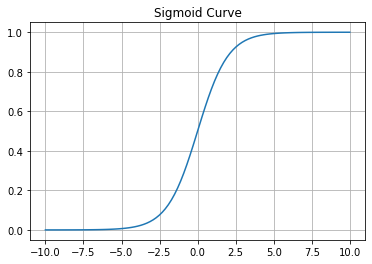

In [3]:
x_s = np.linspace(-10, 10, 100)
plt.figure()
plt.grid()
plt.title('Sigmoid Curve')
plt.plot(x_s, sigmoid(x_s))

As we can see from figure above, the sigmoid curve is limited between 0 and 1. When applied to the output of Linear Regression formula $z=wx+b$, this will effectively limit the output between 0 and 1. This sigmoid activation function output acts as the probability of something classified as TRUE or FALSE. When $\sigma(z) \geq{0.5}$, we can classify the predicted label as TRUE, and when $\sigma(z) < 0.5$, it is classified as FALSE.

Overall flow of logistic regression is pictured below:
<img src="img/logistic-regression-fig.png" width=500 height=500 />

In [4]:
# Logistic regression forward pass
def forward_prop(x, w, b):
    z = np.matmul(w, x) + b
    a = sigmoid(z)
    return a

Next, we will generate some training dataset as the input the logistic regression model. There are 2 inputs to the model $[x_0, x_1]$. Since this is a classification problem, the output $y$ will be $[0, 1]$, and for this notebook, $y$ will be 1 if $x_0 < x_1 $.

In [5]:
# Training input generation
SAMPLE_NM = 1000
x = 10 * np.random.random(size=(2, SAMPLE_NM))
y = np.zeros(shape=(1, SAMPLE_NM))
y[:, x[0, :] < x[1, :]] = 1

Text(0, 0.5, '$x_1$')

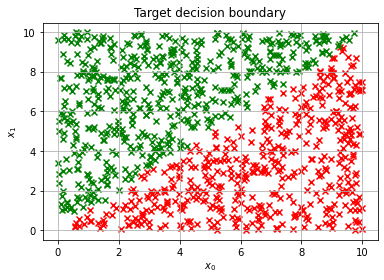

In [6]:
plt.figure()
plt.grid()
plt.title("Target decision boundary")
plt.scatter(x[0, np.argwhere(y == 0)[:, 1]], x[1, np.argwhere(y == 0)[:, 1]], marker='x', c='red')
plt.scatter(x[0, np.argwhere(y == 1)[:, 1]], x[1, np.argwhere(y == 1)[:, 1]], marker='x', c='green')
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")

Figure above represents the decision boundary of classifier that we are going to achieve after training. Green sample represents $y = 1$, and red sample represents $y = 0$

## 1 - Weight Initialization

As pictured in the figure above about the flow of logistic regression, for each input, we have $weight$ to optimize, and additionally, there is 1 $bias$ to optimize. So for this notebook, there are 2 $weight$ value + 1 $bias$ value that will be trained.

For this notebook, let's start with random initialization for both $w$ and $b$. By running the next command, both $w$ and $b$ will be initialized with random value: $-0.5$ $\leq$ $(w, b)$ $\leq$ $0.5$. For optimization reason, $size$ needs to be defined as 2D-shape, and as we have 2 input values, the size of $weight$ is $(1, 2)$, and the $bias$ is $(1, 1)$.

In [7]:
# Initialization
w = np.random.random(size=(1, 2)) - 0.5
b = np.random.random(size=(1, 1)) - 0.5
w_init = np.copy(w) # Backup purpose
b_init = np.copy(b) # Backup purpose
print("w[{}]: {}".format(w.shape, w))
print("b[{}]: {}".format(b.shape, b))

w[(1, 2)]: [[ 0.31151847 -0.02391601]]
b[(1, 1)]: [[0.02315599]]


Initial accuracy: 50.10%


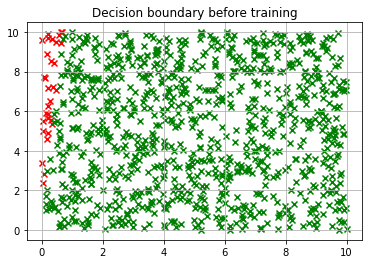

In [8]:
# Initial performance
y_hat = forward_prop(x, w, b)
y_out = np.zeros(shape=y_hat.shape)
y_out[0, y_hat[0, :] >= 0.5] = 1
y_out[0, y_hat[0, :] < 0.5] = 0

plt.figure()
plt.grid()
plt.title("Decision boundary before training")
plt.scatter(x[0, np.argwhere(y_out == 0)[:, 1]], x[1, np.argwhere(y_out == 0)[:, 1]], marker='x', c='red')
plt.scatter(x[0, np.argwhere(y_out == 1)[:, 1]], x[1, np.argwhere(y_out == 1)[:, 1]], marker='x', c='green')

initial_accuracy = np.mean(y_out == y) * 100
print("Initial accuracy: {:.2f}%".format(initial_accuracy))

As this is a binary classification problem, there are only 2 possible outcomes, either TRUE or FALSE. Even if the model always guesses TRUE, if given a balanced dataset, the accuracy will be around 50%. Let's train this model to have better guessing performance.

## 2 - Cost Function

Cost function defines how bad our variable-to-optimize in predicting the label data. Basically, it calculates how big the difference is, between $target$ and the $output$ of our model, given the current value of $w$ and $b$. Previously for linear regression, we use MSE as the cost function, but since the possible outcome of logistic regression is only between 0 and 1, we will use different cost function, which is cross-entropy, which defined as:

$$J = \frac{1}{N} \sum_{i = 0}^{N-1} - (y_{i}\log{\hat{y_{i}}} + (1 - y_{i})\log{(1 - \hat{y_{i}})})$$

and

$$\hat{y_{i}} = \sigma(z) = \frac{1}{1+\exp(-z_{i})}$$

and

$$z_{i}=wx_{i}+b$$

$i$ indicates the index of the training data sample that we have, so $x_{0}$ indicates the first $input$ sample. $\hat{y_{0}}$ indicates the model output when given the first input sample, so this value range is between $0$ and $1$, not only $[0/1]$. $y_{0}$ indicates the $label$, or truth, of the first input sample. 

The intuition behind this cost function is, when given a positive sample [$y_{i} = 1$], only the first part of the equation ($y_{i}\log{\hat{y_{i}}}$) has non-zero value. Since $\hat{y_{i}}$ value is $[0, 1]$, the logarithmic value is negative value, and $-(y_{i}\log{\hat{y_{i}}})$ is positive value. The further $\hat{y_{i}}$ deviates from 1, the bigger the cost value.

And the other way around, when given a negative sample [$y_{i} = 0$], only the second part of the equation ($(1 - y_{i})\log{(1-\hat{y_{i}})}$) has non-zero value. The further $\hat{y_{i}}$ deviates from 0, the bigger the cost value.

In [9]:
# Cost function definition, cross-entropy
def compute_cost(x, y, w, b):
    # Forward propagation
    y_hat = forward_prop(x, w, b)
    
    # Using cross-entropy loss function for classification use case
    N = y.shape[1]
    J = 1 / N * np.sum(-y*np.log(y_hat) - (1-y) * np.log(1-y_hat), axis=1)
    return J.item()

## 3 - Optimization

The purpose of this optimization stage is to adjust the trainable parameter $(w, b)$ to minimize the cost value. This literally means, changing $(w, b)$ so the difference between model $output$ and $target$ value is smaller. 

To modify the trainable parameter $(w, b)$, we need to calculate how each trainable parameter will affect the cost value. This can be done by doing partial derivative of the cost function, with respect to each trainable parameter $(w, b)$. Both weight and bias will be updated following these formula:
$$\begin{align}
w &= w - \alpha\displaystyle \frac{\partial J}{\partial w} \\
\\
b &= b - \alpha\displaystyle \frac{\partial J}{\partial b}
\end{align}$$

$\alpha$ indicates learning rate, which roughly means how big we should update to the trainable parameter. Smaller number indicates slower training process, but less prone to overshoot. Higher number indicates faster training process, but has higher possibilies to overshoot, which means the cost function is actually getting bigger after weight update. Typically we can test out some learning rate such as: $\{0.1, 0.01, 0.001, ...\}$.

One thing to note is, loss function and cost function is similar, but a bit different term. Loss function is for single sample in the training set, while cost function is averaging the loss over all sample in the training set. While calculating the partial derivative of the cost function, it is fine to forget the summation notation used in the cost function.

### 3.1 - Backward Propagation - Partial Derivatives

From the cost function:

$$J = \frac{1}{N} \sum_{i = 0}^{N-1} -(y_{i}\log{\hat{y_{i}}} + (1 - y_{i})\log{(1-\hat{y_{i}})})$$

we can forget the averaging part and focus on the loss function for a single sample, and to simplify the formula, we can change the term $\hat{y}$ as $a$, and the formulas can be redefined as:

$$
\begin{align}
L &= -(y\log{a} + (1 - y)\log{(1 - a)}) \\
\\
a &= \frac{1}{1 + \exp(-z)} \\
\\
z &= wx + b
\end{align}
$$

For the first formula, we can calculate the partial derivative as:
$$
\begin{align}
L &= -(y\log{a} + (1 - y)\log{(1 - a)}) \\
\\
\displaystyle \frac{\partial L}{\partial a} &= -\left(\frac{y}{a} + (1 - y)(-1)\frac{1}{(1 - a)}\right) \\
&= -\left(\frac{y}{a} - \frac{1 - y}{1 - a}\right) \\
&= -\left(\frac{y(1 - a) - a(1 - y)}{a(1 - a)}\right)\\
&= \frac{a - y}{a(1 - a)}\\
\\
\end{align}
$$

As for the second formula:

$$
\begin{align}
a &= \frac{1}{1 + \exp(-z)} \\
\\
\displaystyle \frac{\partial a}{\partial z} &= a(1 - a) \\
\end{align}
$$

And for the third formula:

$$z = wx + b$$

$$\displaystyle \frac{\partial z}{\partial x} = x, \displaystyle \frac{\partial z}{\partial b} = 1$$

Now we can start calculating both $\displaystyle \frac{\partial L}{\partial w}$ and $\displaystyle \frac{\partial L}{\partial b}$, by using Chain Rule:

$$
\begin{align}
\displaystyle \frac{\partial L}{\partial w} &= \displaystyle \frac{\partial L}{\partial a} \displaystyle \frac{\partial a}{\partial z} \displaystyle \frac{\partial z}{\partial w} \\
&= \frac{a - y}{a(1 - a)} \cdot a(1 - a) \cdot x\\
&= (a - y) \cdot x\\
\\
\displaystyle \frac{\partial J}{\partial w} &= \frac{1}{N} \sum_{i = 0}^{N-1} (\hat{y_{i}} - y_{i}) \cdot x_{i} \\
\\
\\
\displaystyle \frac{\partial L}{\partial b} &= \displaystyle \frac{\partial L}{\partial a} \displaystyle \frac{\partial a}{\partial z} \displaystyle \frac{\partial z}{\partial b} \\
&= \frac{a - y}{a(1 - a)} \cdot a(1 - a) \cdot 1\\
&= (a - y)\\
\\
\displaystyle \frac{\partial J}{\partial b} &= \frac{1}{N} \sum_{i = 0}^{N-1} (\hat{y_{i}} - y_{i}) \\
\end{align}
$$

We've finished the difficult part, now let's implement this in the code.

In [10]:
# Training
EPOCH_NM = 10000
cost_history = [compute_cost(x, y, w, b)]

for epoch in range(EPOCH_NM):

    # Forward propagation
    y_hat = forward_prop(x, w, b)
    
    # Backward propagation
    N = y.shape[1]
    dJw = 1 / N * np.matmul(y_hat - y, x.T)
    dJb = 1 / N * np.sum(y_hat - y)
    
    # Update weight
    L_RATE = 1e-3
    w = w - L_RATE * dJw
    b = b - L_RATE * dJb
    
    # Check cost
    cost = compute_cost(x, y, w, b)
    cost_history.append(cost)
    
print("Initial cost: {:.6f}".format(cost_history[0]))
print("Final cost: {:.6f}".format(cost_history[-1]))

Initial cost: 1.217663
Final cost: 0.110057


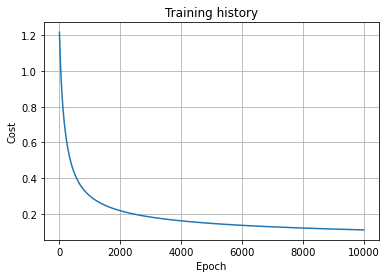

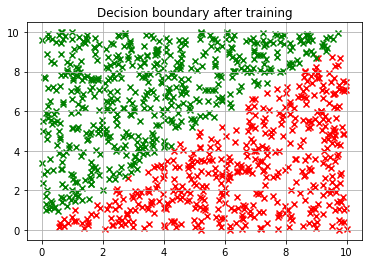

In [11]:
# Plot training history
plt.figure()
plt.title("Training history")
plt.grid()
plt.plot(cost_history)
plt.xlabel("Epoch")
plt.ylabel("Cost")

# Final performance
y_hat = forward_prop(x, w, b)
y_out = np.zeros(shape=y_hat.shape)

# Thresholding, because the model output is just probability, not TRUE/FALSE value
y_out[0, y_hat[0, :] >= 0.5] = 1
y_out[0, y_hat[0, :] < 0.5] = 0

plt.figure()
plt.grid()
plt.title("Decision boundary after training")
plt.scatter(x[0, np.argwhere(y_out == 0)[:, 1]], x[1, np.argwhere(y_out == 0)[:, 1]], marker='x', c='red')
plt.scatter(x[0, np.argwhere(y_out == 1)[:, 1]], x[1, np.argwhere(y_out == 1)[:, 1]], marker='x', c='green')

In [12]:
# Final accuracy
final_accuracy = np.mean(y_out == y) * 100
print("Initial accuracy: {:.2f}%".format(initial_accuracy))
print("Final accuracy: {:.2f}%".format(final_accuracy))

Initial accuracy: 50.10%
Final accuracy: 99.30%


Congratulation! You've finished for very first binary classifier! The decision boundary after training seems very similar with the target decision boundary that we created at the very beginning of this notebook.